# 聊天记录综合分析报告

本项目旨在对微信聊天记录进行深入分析。通过利用 Python 的数据分析和可视化库，我们将从多个维度探索聊天数据，包括消息活跃度、发言习惯、关键词云、情绪变化趋势以及消息类型分布等。

分析流程如下：
1.  **环境设置与数据准备**：配置必要的库和字体，加载并清洗数据。
2.  **基本统计**：分析总体消息量、各成员发言量等。
3.  **活跃度分析**：探究在不同时间尺度（按天、按小时）下的消息频率。
4.  **文本内容分析**：通过词云图展示高频词汇。
5.  **情绪分析**：利用 Hugging Face 的 RoBERTa 中文预训练模型对文本消息进行情感推理，计算积极/消极概率，并绘制情绪热力图与波动曲线。
6.  **AI聊天分析报告**：通过调用 Deepseek API 生成专业有趣的聊天内容分析报告

## 1. 环境设置与数据准备

在这一步，我们将安装并导入所有分析所需的库，配置Matplotlib以正确显示中文，然后加载并预处理我们的聊天数据。

In [1]:
# -*- coding: utf-8 -*-
import os
import json
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import jieba

from collections import Counter
import re
import requests # 用于AI报告
from pyecharts.charts import Calendar # 用于热力图
from pyecharts import options as opts # 用于热力图

# 设置字体为 'SimHei'
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

print("\n所有库导入完毕，字体配置完成。")

d:\Anaconda\Lib\site-packages\jieba\_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources



所有库导入完毕，字体配置完成。


In [2]:
# 3. 加载和预处理数据
def load_and_preprocess_data(json_path):
    print(f"开始从 {json_path} 加载数据...")
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"错误：找不到文件 {json_path}。请确保文件名和路径正确。")
        return None
    except json.JSONDecodeError:
        print(f"错误：无法解析 {json_path}。请检查文件格式是否为有效的JSON。")
        return None

    # 处理嵌套的JSON，提取消息列表
    # 如果 'messages' 键存在，则使用其值；否则，假定整个文件就是消息列表
    data = data.get('messages', data)

    # 转换为DataFrame
    df = pd.DataFrame(data)
    print(f"成功加载 {len(df)} 条消息。")

    # --- 数据清洗和特征工程 ---
    rename_map = {
        'formattedTime': 'time',
        'senderDisplayName': 'sender'
    }
    df.rename(columns=rename_map, inplace=True)
    # 转换时间戳
    df['time'] = pd.to_datetime(df['time'])
    
    # 提取日期和小时
    df['date'] = df['time'].dt.date
    df['hour'] = df['time'].dt.hour
    
    # 提取消息类型
    # 'type' 列可能不存在，使用 .get() 避免错误
    df['message_type'] = df.apply(lambda row: row.get('type', '未知'), axis=1)

    print("数据预处理完成。")
    
    return df

# --- 执行数据加载 ---
# 定义文件路径
JSON_FILE_PATH = 'data.json'

# 加载数据
chat_df = load_and_preprocess_data(JSON_FILE_PATH)

print("\n数据加载完成")   

开始从 data.json 加载数据...
成功加载 9961 条消息。
数据预处理完成。

数据加载完成


## 2. 基本统计分析

在数据准备好之后，我们首先进行一些基本的统计，以了解聊天概况，例如总消息量、每个成员的发言量等。

总消息数: 9961
\n--- 每人发言数量 ---
sender
好友    6204
我     3757
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_38416\814042521.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sender_counts.index, y=sender_counts.values, palette='viridis')


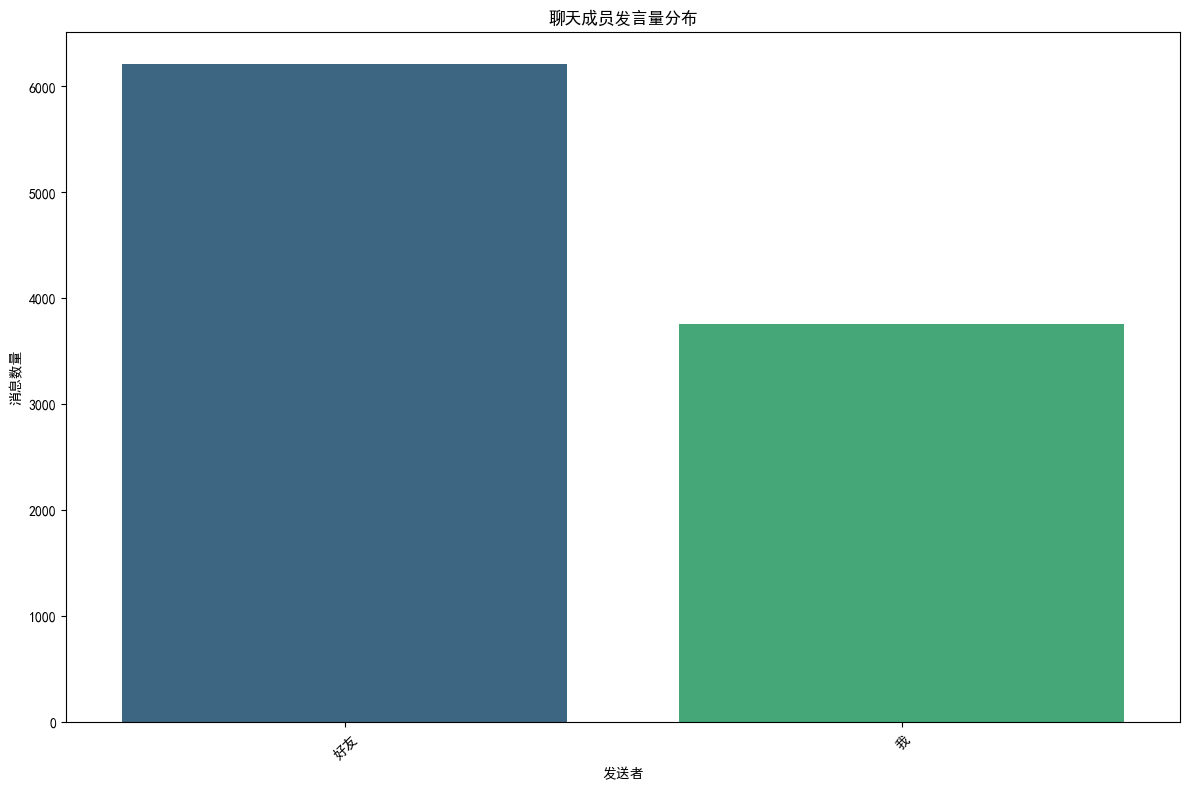

\n--- 消息类型分布 ---
message_type
文本消息                  7760
动画表情                   804
图片消息                   454
引用消息                   406
语音消息                   178
图文消息                    92
聊天记录合并转发                69
卡片式链接                   46
系统消息                    44
文件消息                    27
通话消息                    24
视频消息                    22
转账卡片                    20
位置消息                     4
拍一拍消息                    4
未知类型(219043332145)       2
未知类型(141733920817)       2
红包卡片                     1
小程序分享                    1
未知类型(73014444081)        1
Name: count, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_38416\814042521.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=message_type_counts.index, y=message_type_counts.values, palette='magma')


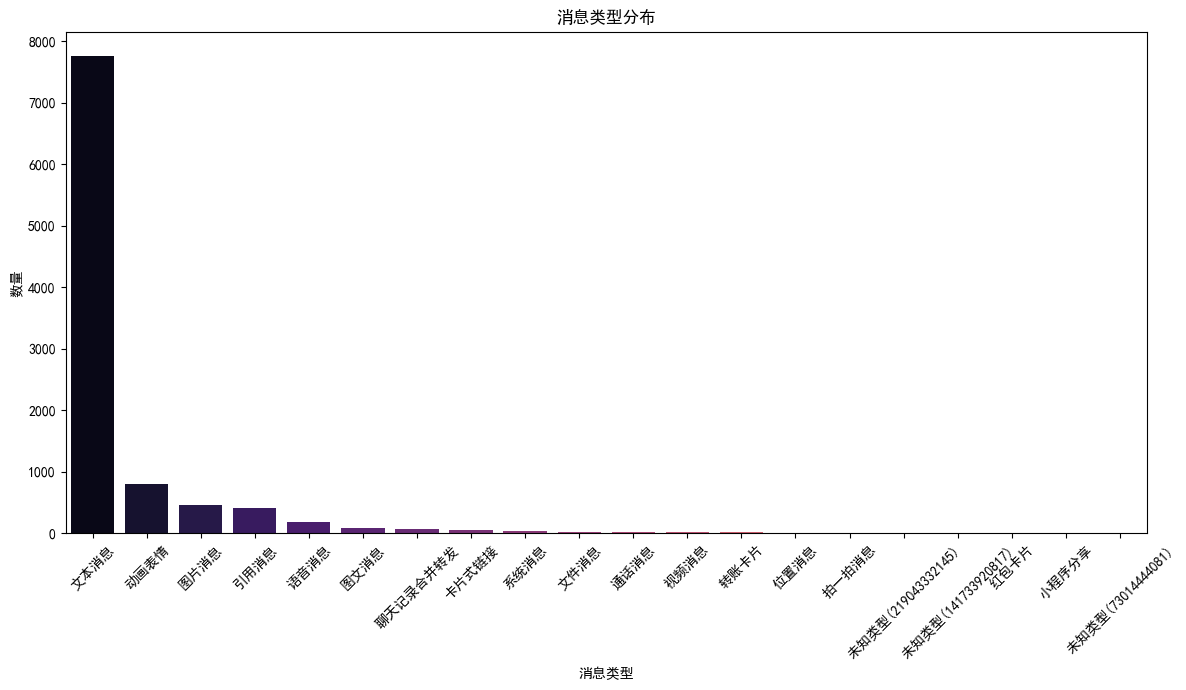

In [3]:
if 'chat_df' in locals() and chat_df is not None:
    # --- 基本统计 ---
    # 计算总消息数
    total_messages = len(chat_df)
    print(f"总消息数: {total_messages}")

    # 计算每个发送者的消息数
    sender_counts = chat_df['sender'].value_counts()
    print("\\n--- 每人发言数量 ---")
    print(sender_counts)

    # 可视化发言人分布
    plt.figure(figsize=(12, 8))
    sns.barplot(x=sender_counts.index, y=sender_counts.values, palette='viridis')
    plt.title('聊天成员发言量分布')
    plt.xlabel('发送者')
    plt.ylabel('消息数量')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- 消息类型分析 (合并) ---
    message_type_counts = chat_df['message_type'].value_counts()
    print("\\n--- 消息类型分布 ---")
    print(message_type_counts)
    
    # 可视化消息类型分布
    plt.figure(figsize=(12, 7))
    sns.barplot(x=message_type_counts.index, y=message_type_counts.values, palette='magma')
    plt.title('消息类型分布')
    plt.xlabel('消息类型')
    plt.ylabel('数量')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("数据未成功加载，请先执行前面的数据加载步骤。")

## 3. 活跃度分析

本部分将分析聊天活跃度随时间的变化趋势，包括每日消息量和每小时消息分布。

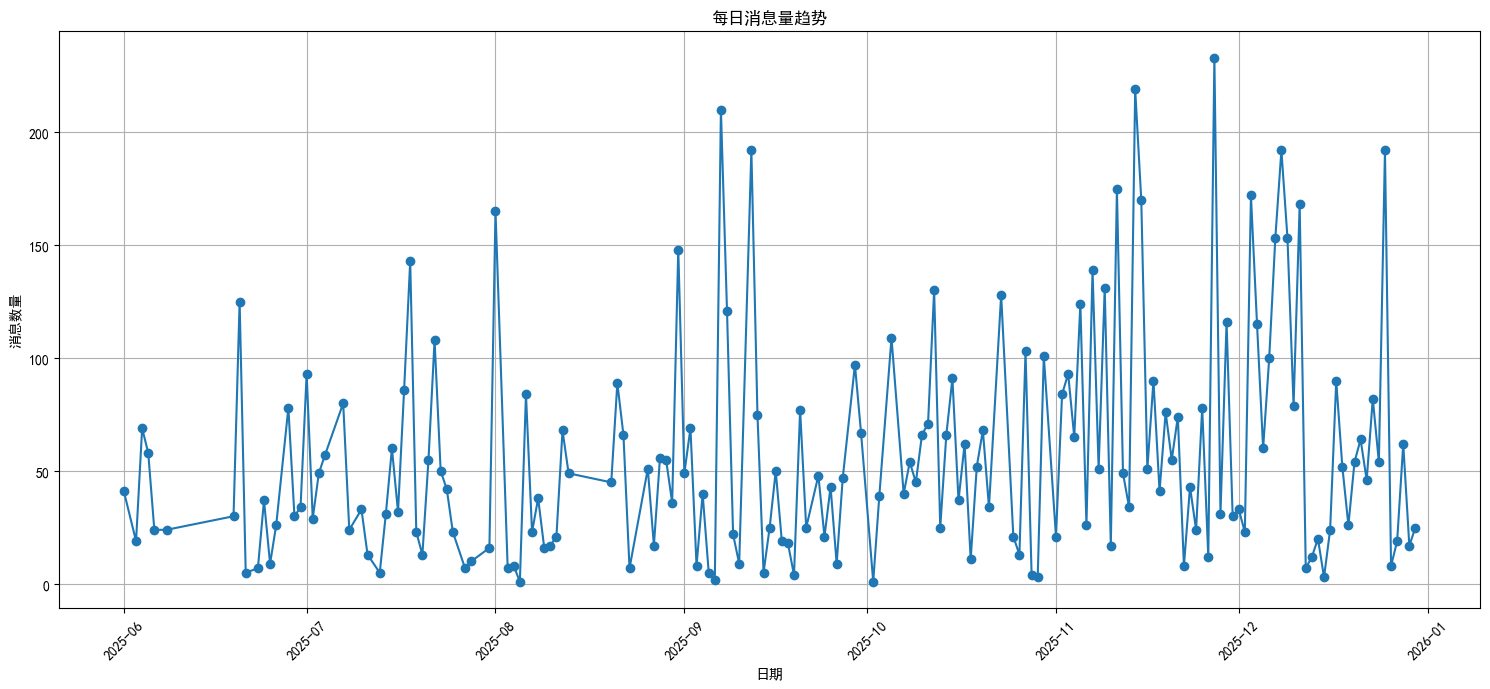

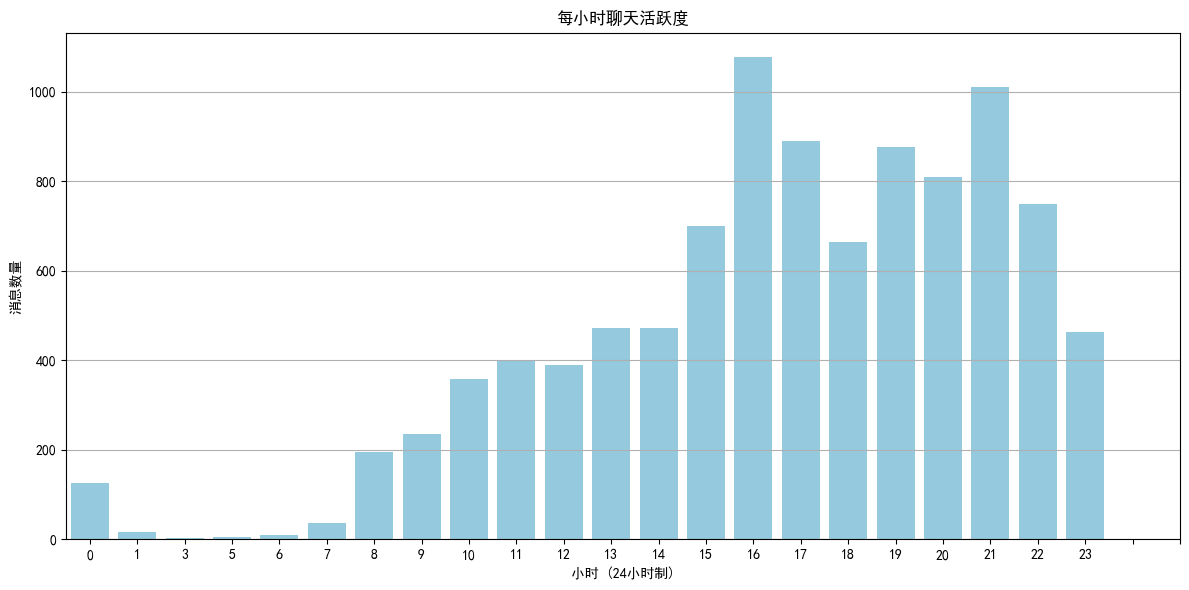

In [ ]:
if 'chat_df' in locals() and chat_df is not None:
    # --- 每日消息趋势 ---
    daily_trend = chat_df.groupby('date').size()
    
    plt.figure(figsize=(15, 7))
    daily_trend.plot(kind='line', marker='o', linestyle='-')
    plt.title('每日消息量趋势')
    plt.xlabel('日期')
    plt.ylabel('消息数量')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # --- 每小时活跃度分布 ---
    hourly_activity = chat_df.groupby('hour').size()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=hourly_activity.index, y=hourly_activity.values, color='skyblue')
    plt.title('每小时聊天活跃度')
    plt.xlabel('小时 (24小时制)')
    plt.ylabel('消息数量')
    plt.xticks(range(0, 24))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    # 将 pyecharts 图表作为单元格的最后输出来渲染
    calendar.render_notebook()

else:
    print("数据未成功加载，请先执行前面的数据加载步骤。")

## 4. 文本内容分析 (词云)

为了直观地展示聊天中最常讨论的话题，我们创建一个词云。这需要提取所有文本消息，使用`jieba`进行中文分词，并过滤掉常见的停用词。

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\user\AppData\Local\Temp\jieba.cache


成功从 stop words.txt 加载 4011 个停用词。


Loading model cost 0.800 seconds.
Prefix dict has been built successfully.


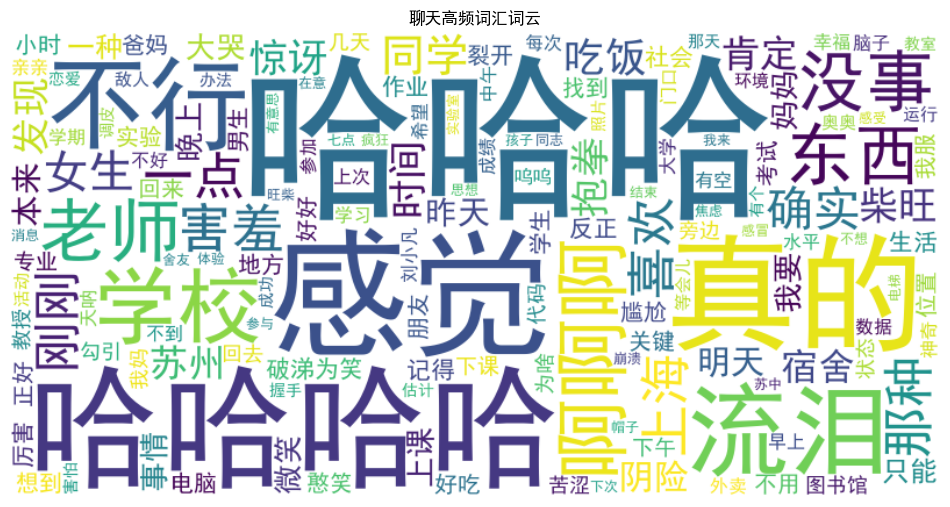

In [5]:
if 'chat_df' in locals() and chat_df is not None:
    # --- 词云生成 ---
    
    # 1. 从文件加载停用词
    def load_stopwords(filepath):
        """从文件加载停用词列表"""
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                stopwords = {line.strip() for line in f}
            print(f"成功从 {filepath} 加载 {len(stopwords)} 个停用词。")
            # 添加一些默认的、可能缺失的停用词
            stopwords.update(["图片", "表情", "语音", "视频", "文件", "红包", "转账", "链接", "[图片]", "[表情]", "撤回了一条消息", "拍了拍"])
            return stopwords
        except FileNotFoundError:
            print(f"错误：找不到停用词文件 {filepath}。请确保文件存在。")
            return set()

    stopwords_path = 'stop words.txt'
    stopwords = load_stopwords(stopwords_path)

    # 2. 提取所有文本消息
    # 确保只处理 'Text' 类型的消息，并且内容是字符串
    text_messages = chat_df[chat_df['message_type'] == '文本消息']['content'].dropna().astype(str)
    full_text = " ".join(text_messages)

    # 3. 中文分词
    # 使用正则表达式去除所有非中文字符，只保留汉字用于分词
    chinese_only_text = re.sub(r"[^\u4e00-\u9fa5]+", "", full_text)
    words = jieba.cut(chinese_only_text)
    
    # 4. 过滤停用词
    filtered_words = [word for word in words if len(word) > 1 and word not in stopwords]
    
    # 5. 检查过滤后是否还有词
    if not filtered_words:
        print("警告：在过滤停用词后，没有剩余的词语可用于生成词云。")
    else:
        # 6. 生成词云
        word_freq = Counter(filtered_words)
        
        # 选择一个系统中可能存在的中文字体
        font_path = 'C:/Windows/Fonts/simhei.ttf'
        if not os.path.exists(font_path):
            print(f"警告: 找不到字体 {font_path}。词云可能无法正确显示中文。")
            print("请根据您的操作系统修改为正确的字体路径。")
            # 在Windows上，可以尝试 'msyh.ttc' (微软雅黑)
            font_path = 'C:/Windows/Fonts/msyh.ttc' 
            if not os.path.exists(font_path):
                font_path = None # 如果都找不到，则不指定字体路径

        try:
            wordcloud = WordCloud(
                width=800, 
                height=400, 
                background_color='white',
                font_path=font_path, # 指定中文字体路径
                stopwords=stopwords,
                max_words=150,
                colormap='viridis'
            ).generate_from_frequencies(word_freq)

            plt.figure(figsize=(12, 8))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title('聊天高频词汇词云')
            plt.show()
        except Exception as e:
            print(f"生成词云时发生错误: {e}")
            if "font" in str(e).lower():
                print("错误很可能与字体有关。请检查 `font_path` 是否指向一个有效的中文字体文件。")

else:
    print("数据未成功加载，请先执行前面的数据加载步骤。")

## 5. 情绪分析

本节基于 Hugging Face Transformers 框架，调用 RoBERTa 中文预训练模型（uer/roberta-base-finetuned-jd-binary-chinese）进行情感计算。通过情绪热力图 (Heatmap) 与带有峰值标注的时序折线图，精准定位情绪波动异常点及高光/低谷时刻。

d:\Anaconda\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
d:\Anaconda\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


聊天记录分析中... 总文本数量: 7760 条
正在加载模型 (uer/roberta-base-finetuned-jd-binary-chinese)...
模型就绪，开始分析...
进度: 7600/7760
分析完成！正在生成双人对比报告...


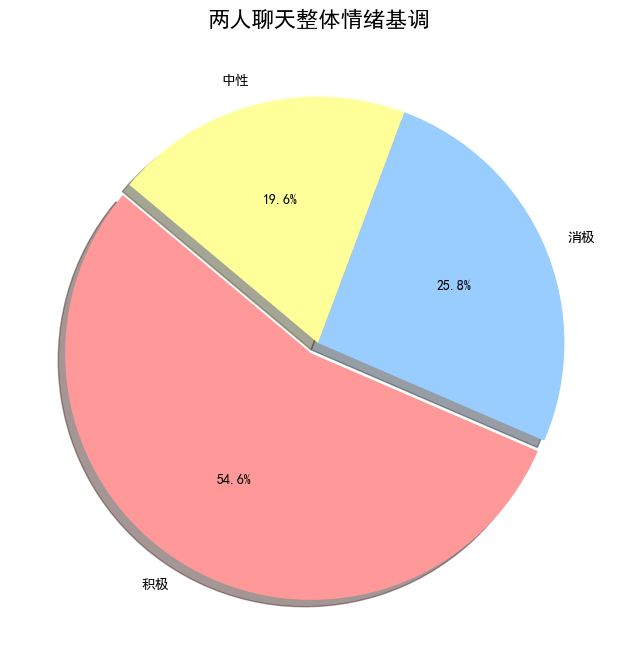

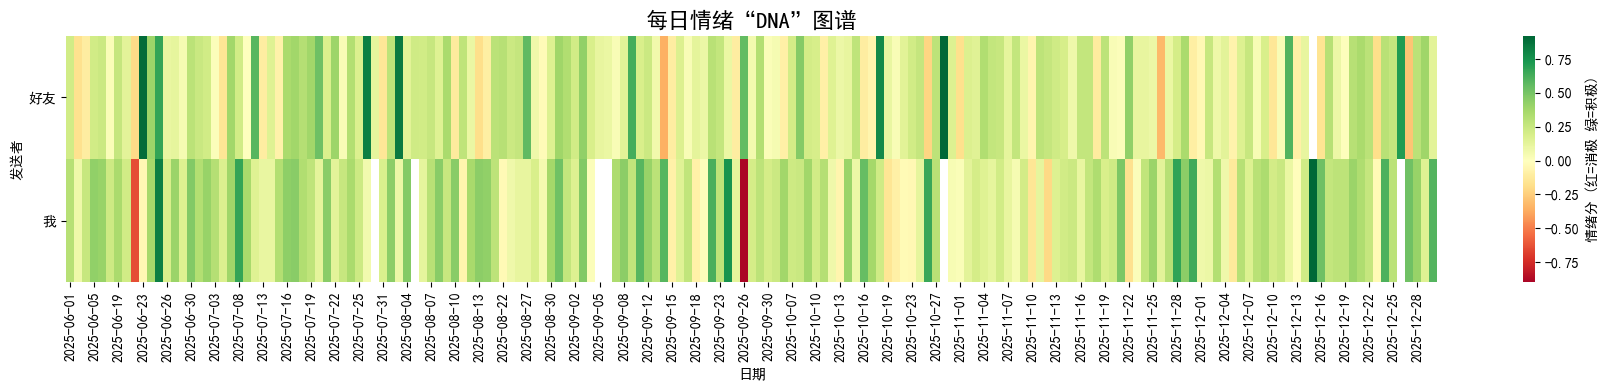

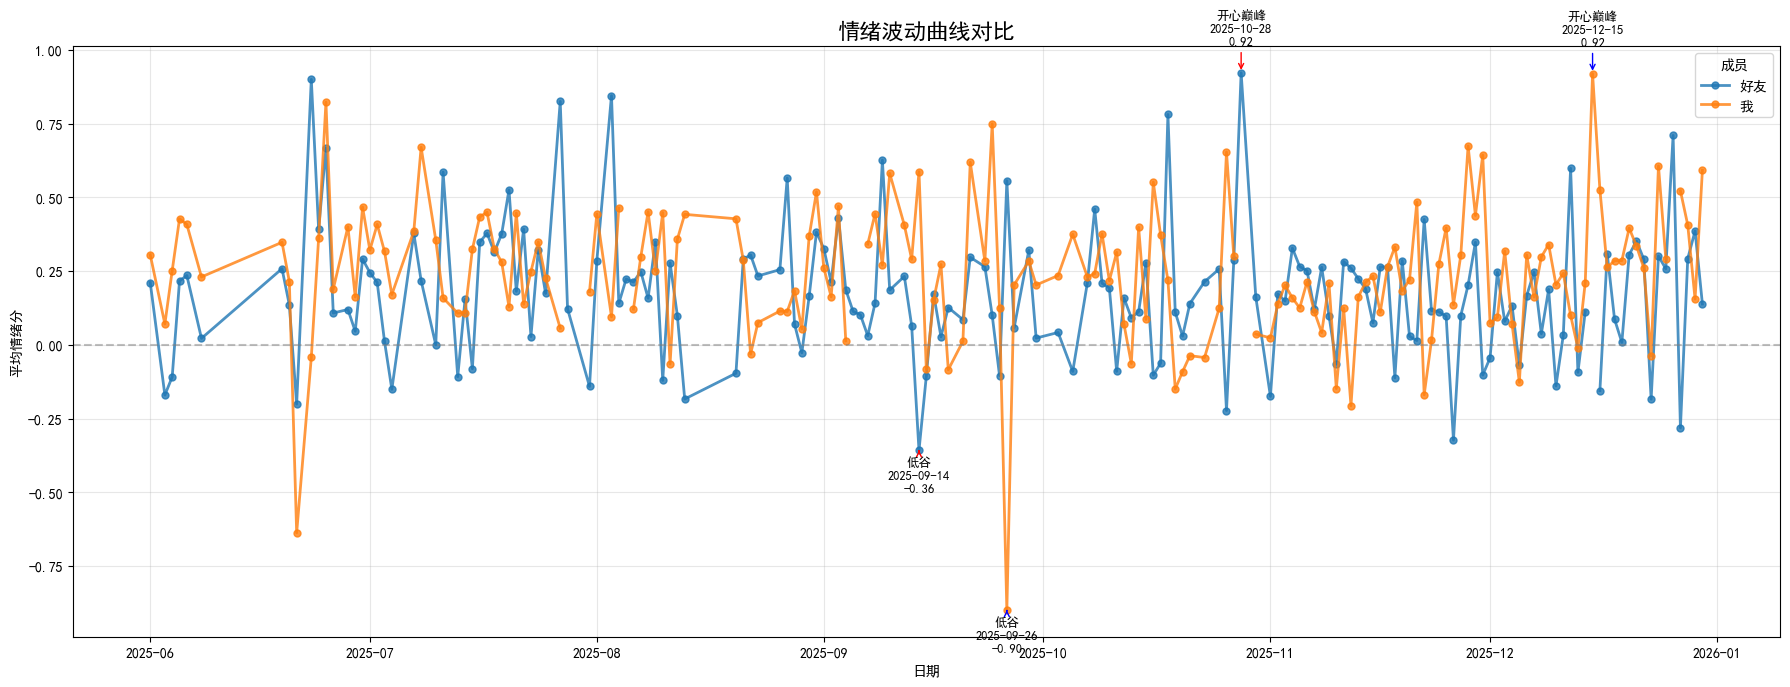


 异常情绪事件回溯报告

气氛最压抑的 3 天 (发生了什么？):

日期: 2025-06-21 (平均分: -0.35)
   💣 最丧时刻: "真的笑鼠我了"
   👤 发送者: 我

日期: 2025-12-23 (平均分: -0.14)
   💣 最丧时刻: "尼玛"
   👤 发送者: 好友

日期: 2025-11-01 (平均分: -0.14)
   💣 最丧时刻: "草"
   👤 发送者: 好友

气氛最欢快的 3 天:

日期: 2025-10-28 (平均分: 0.92)
   高光时刻: "好"
  发送者: 好友

日期: 2025-12-15 (平均分: 0.92)
   高光时刻: "哈哈哈哈哈太真实了"
  发送者: 我

日期: 2025-06-25 (平均分: 0.74)
   高光时刻: "感觉不知道为什么就是写得很好还有很多狗粮哈哈哈"
  发送者: 好友



In [ ]:
# ==========================================
# 1. 环境与配置
import os
# 防止 OpenMP 冲突
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
# 使用国内镜像加速模型下载
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import warnings

warnings.filterwarnings("ignore")
# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS'] 
plt.rcParams['axes.unicode_minus'] = False

device = -1 # 使用 CPU

# ==========================================
# 2. 准备数据
# ==========================================
if 'chat_df' in locals() and chat_df is not None:
    # 提取关键列
    text_df = chat_df[chat_df['message_type'] == '文本消息'][['content', 'date', 'hour', 'sender']].copy()
    text_df.dropna(subset=['content'], inplace=True)
    text_df['content'] = text_df['content'].astype(str).str.strip()
    text_df = text_df[text_df['content'] != '']
    
    total_count = len(text_df)
    print(f"聊天记录分析中... 总文本数量: {total_count} 条")
    
    analysis_df = text_df.copy()    
    text_list = analysis_df['content'].tolist()

    # ==========================================
    # 3. 加载模型 & 推理
    # ==========================================
    print("正在加载模型 (uer/roberta-base-finetuned-jd-binary-chinese)...")
    model_name = "uer/roberta-base-finetuned-jd-binary-chinese"
    
    try:
        classifier = pipeline("sentiment-analysis", model=model_name, device=device)
        print("模型就绪，开始分析...")

        results = []
        for i, text in enumerate(text_list):
            try:
                res = classifier(text[:512])[0]
                results.append(res)
            except:
                results.append({'label': 'neutral', 'score': 0.5})
            
            if (i + 1) % 200 == 0:
                print(f"进度: {i + 1}/{len(text_list)}", end='\r')
        
        print("\n分析完成！正在生成双人对比报告...")

        # ==========================================
        # 4. 数据处理：计算分数
        # ==========================================
        probs = []
        final_labels = [] 
        
        for res in results:
            label = res['label']
            score = res['score']
            
            if 'positive' in label:
                prob = score
            else:
                prob = 1 - score 
            
            probs.append(prob)
            
            # 0.4 - 0.6 之间算中性
            if prob >= 0.6:
                final_labels.append('积极')
            elif prob <= 0.4:
                final_labels.append('消极')
            else:
                final_labels.append('中性')

        analysis_df['positive_prob'] = probs
        analysis_df['sentiment'] = final_labels
        # 计算数值分：积极=1, 中性=0, 消极=-1，用于画线
        analysis_df['sentiment_score'] = (analysis_df['positive_prob'] - 0.5) * 2

        # ==========================================
        # 5. 可视化展示 (Pie + Heatmap + Line)
        # ==========================================
        
        # --- 图表 1: 整体情绪分布饼图---
        plt.figure(figsize=(8, 8))
        counts = analysis_df['sentiment'].value_counts()
        colors = {'积极': '#ff9999', '中性': '#ffff99', '消极': '#99ccff'} # 粉红、淡黄、天蓝
        
        # 绘制饼图
        patches, texts, autotexts = plt.pie(
            counts, 
            labels=counts.index, 
            autopct='%1.1f%%', 
            colors=[colors.get(x, '#cccccc') for x in counts.index], 
            startangle=140,
            explode=(0.05, 0, 0) if len(counts) == 3 else None, #稍微突出第一块
            shadow=True
        )
        plt.title('两人聊天整体情绪基调', fontsize=16)
        plt.show()

        # --- 图表 2: 每日情绪热力图 (双人并排) ---
        # 制作透视表：行=人，列=日期
        heatmap_data = analysis_df.pivot_table(index='sender', columns='date', values='sentiment_score', aggfunc='mean')
        
        # 动态调整高度：因为只有2行，高度设小一点，宽度设大一点
        plt.figure(figsize=(18, 4)) 
        sns.heatmap(
            heatmap_data, 
            cmap='RdYlGn', # 红黄绿配色
            center=0, 
            annot=False,   # 不显示数字，太乱
            cbar_kws={'label': '情绪分 (红=消极 绿=积极)'},
            square=False   # 允许长方形格子
        )
        plt.title('每日情绪“DNA”图谱', fontsize=16)
        plt.xlabel('日期')
        plt.ylabel('发送者')
        plt.yticks(rotation=0) # 名字横着放
        plt.tight_layout()
        plt.show()

        # --- 图表 3: 带有标注的波动折线图 (重点优化) ---
        plt.figure(figsize=(18, 7))
        daily_trend = analysis_df.groupby(['date', 'sender'])['sentiment_score'].mean().unstack()
        
        # 画线
        ax = daily_trend.plot(kind='line', marker='o', markersize=5, linewidth=2, alpha=0.8, ax=plt.gca())
        
        # 自动标注最高点和最低点
        colors_list = ['red', 'blue', 'green', 'orange'] # 备选颜色
        for idx, person in enumerate(daily_trend.columns):
            person_data = daily_trend[person].dropna()
            if len(person_data) == 0: continue
            
            # 找最高点
            max_date = person_data.idxmax()
            max_val = person_data.max()
            ax.annotate(f'开心巅峰\n{max_date}\n{max_val:.2f}', 
                        xy=(max_date, max_val), xytext=(0, 20), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->", color=colors_list[idx%4]), ha='center', fontsize=9)
            
            # 找最低点
            min_date = person_data.idxmin()
            min_val = person_data.min()
            ax.annotate(f'低谷\n{min_date}\n{min_val:.2f}', 
                        xy=(min_date, min_val), xytext=(0, -30), textcoords='offset points',
                        arrowprops=dict(arrowstyle="->", color=colors_list[idx%4]), ha='center', fontsize=9)

        plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
        plt.title('情绪波动曲线对比', fontsize=16)
        plt.ylabel('平均情绪分')
        plt.xlabel('日期')
        plt.grid(True, alpha=0.3)
        plt.legend(title='成员')
        plt.tight_layout()
        plt.show()

        # ==========================================
        # 6. 异常事件回溯报告 (重点优化)
        # ==========================================
        print("\n" + "="*40)
        print(" 异常情绪事件回溯报告")
        print("="*40)
        
        # 计算每一天的整体平均分 (两人加权)
        daily_avg = analysis_df.groupby('date')['sentiment_score'].mean()
        
        # --- 1. 寻找最不开心的 3 天 ---
        print("\n气氛最压抑的 3 天 (发生了什么？):")
        worst_days = daily_avg.nsmallest(3)
        
        for date, score in worst_days.items():
            print(f"\n日期: {date} (平均分: {score:.2f})")
            # 找出这一天里，分数最低的那条消息
            day_msgs = analysis_df[analysis_df['date'] == date]
            min_msg_idx = day_msgs['sentiment_score'].idxmin()
            msg_row = day_msgs.loc[min_msg_idx]
            print(f"   💣 最丧时刻: \"{msg_row['content']}\"")
            print(f"   👤 发送者: {msg_row['sender']}")
            
        # --- 2. 寻找最开心的 3 天 ---
        print("\n气氛最欢快的 3 天:")
        best_days = daily_avg.nlargest(3)
        
        for date, score in best_days.items():
            print(f"\n日期: {date} (平均分: {score:.2f})")
            # 找出这一天里，分数最高的那条消息
            day_msgs = analysis_df[analysis_df['date'] == date]
            max_msg_idx = day_msgs['sentiment_score'].idxmax()
            msg_row = day_msgs.loc[max_msg_idx]
            print(f"   高光时刻: \"{msg_row['content']}\"")
            print(f"  发送者: {msg_row['sender']}")

        print("\n" + "="*40)

    except Exception as e:
        print(f"发生错误: {e}")
        import traceback
        traceback.print_exc()
else:
    print("请先加载数据")

## 7. AI 生成的分析报告 (DeepSeek)

本部分通过调用外部的 AI 模型（如 DeepSeek）来生成一份关于聊天内容的摘要和分析报告。这可以提供一个更宏观、更具洞察力的视角。

In [7]:
def generate_ai_report(api_key, chat_dataframe, top_n=10):
    """
    使用DeepSeek API生成聊天记录的AI分析报告。
    
    Args:
        api_key (str): DeepSeek API密钥。
        chat_dataframe (pd.DataFrame): 包含聊天记录的DataFrame。
        top_n (int): 用于分析的最高频词数量。
    """
    if not api_key or api_key == "YOUR_DEEPSEEK_API_KEY":
        print("警告：未提供有效的DeepSeek API Key。跳过AI报告生成。")
        print("请访问 https://platform.deepseek.com/api_keys 获取您的密钥。")
        return

    print("\\n" + "="*60)
    print("正在生成AI分析报告 (Powered by DeepSeek)...")
    print("="*60)

    # 1. 准备报告所需的数据
    total_messages = len(chat_dataframe)
    duration_days = (chat_dataframe['date'].max() - chat_dataframe['date'].min()).days
    sender_counts = chat_dataframe['sender'].value_counts()
    
    # 准备文本内容进行分词
    text_content = " ".join(chat_dataframe[chat_dataframe['message_type'] == 'Text']['content'].dropna().astype(str))
    words = [word for word in jieba.cut(text_content) if len(word) > 1 and word not in stopwords]
    top_words = Counter(words).most_common(top_n)

    # 2. 构建Prompt
    prompt = f"""
    请根据以下聊天数据摘要，生成一份简短、深刻的中文分析报告。报告应包括：
    1.  对整体聊天风格和氛围的总结。
    2.  对主要参与者的沟通模式的简要分析。
    3.  基于高频词汇，推断出他们可能的核心话题或关系特点。
    4.  提出一两个有趣的观察或结论。

    **数据摘要:**
    - **时间跨度**: {duration_days} 天
    - **总消息数**: {total_messages} 条
    - **参与者消息分布**:
"""
    for sender, count in sender_counts.items():
        prompt += f"      - {sender}: {count} 条 ({count/total_messages:.1%})\\n"
    
    prompt += f"- **讨论的 Top {top_n} 高频词汇**: {', '.join([word for word, count in top_words])}\\n"

    prompt += "\n**分析报告:**\n"

    # 3. 调用API
    try:
        url = "https://api.deepseek.com/chat/completions"
        headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        payload = {
            "model": "deepseek-chat",
            "messages": [
                {"role": "system", "content": "你是一位精通社会学和心理学的数据分析师，擅长从沟通数据中发现深层关系和模式。"},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.7,
            "stream": False
        }
        
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status() # 如果请求失败则抛出异常
        
        result = response.json()
        report_content = result['choices'][0]['message']['content']
        
        print("--- AI 分析报告 ---")
        print(report_content)
        print("--------------------")

    except requests.exceptions.RequestException as e:
        print(f"调用AI报告API时出错: {e}")
    except (KeyError, IndexError):
        print("解析AI报告API响应时出错，请检查返回的数据格式。")


# --- 执行AI报告生成 ---
# 读取配置中的DeepSeek API Key
try:
    from config import DEEPSEEK_API_KEY
    api_key = DEEPSEEK_API_KEY
except:
    api_key = None

if 'chat_df' in locals() and chat_df is not None:
    generate_ai_report(api_key, chat_df)
else:
    print("数据未成功加载，请先执行AI报告生成步骤。")

\n============================================================
正在生成AI分析报告 (Powered by DeepSeek)...
--- AI 分析报告 ---
### 聊天数据分析报告

#### 1. 整体聊天风格与氛围
在长达212天的持续互动中，两位参与者共交换了近万条消息，形成了**高频、紧密且高度日常化**的沟通模式。聊天氛围整体呈现出**轻松、信任、生活化**的特点，双方建立了稳定的分享习惯。好友在消息数量上占据主导（62.3%），显示出更强的表达欲和分享主动性，而“我”则扮演了积极的倾听与回应者角色。这种不对等的消息量并未破坏平衡，反而可能暗示了一种**默契的互补关系**。

#### 2. 主要参与者沟通模式分析
- **好友（主导分享者）**：其沟通模式具有**高频率、细节丰富、情感外露**的特点。占据六成以上的消息量，表明其习惯于将日常琐事、即时情绪与想法进行持续性输出。这种模式可能源于强烈的表达需求、对关系的信任，或希望通过分享来维系亲密感。
- **“我”（积极回应者）**：虽然消息量较少，但近38%的占比在长期对话中仍属高度参与。其模式更偏向**倾听、承接话题、提供情感反馈或实用建议**。这种“回应型”沟通维系了对话的流动性，并可能为好友的分享提供了稳定的情感容器。

#### 3. 高频词汇揭示的核心话题与关系特点
从高频词分析，对话核心紧密围绕**两人共同的现实生活与情感世界**：
- **生活实景（“今天”、“吃”、“哈哈”、“回家”、“睡觉”）**：词汇极具日常性与即时性，表明聊天是彼此**生活节奏同步与陪伴**的重要方式。分享三餐、作息、日常趣事（“哈哈”）构成了关系的基底。
- **关系指向（“你”、“我”、“宝宝”）**：人称代词的高频使用凸显对话的**直接性与互动性**。“宝宝”一词的出现（即便频率不高）是重要信号，可能暗示着**亲密昵称、恋人关系或深厚的情感依恋**，这是定义关系性质的关键词。
- **情感与状态（“感觉”、“现在”）**：注重分享当下心境与感受，沟通具有**情感流动与状态同步**的特点，而非单纯事务性交流。

**核心推断**：两人很可能处于**亲密关系（如恋人或挚友）**中，聊天主要功能是**维系日常情感连接、分享生活实感、提供陪伴*